# Washington D.C. Bike share Predic Model

● Using a complete 2011 - 2012 dataset (kaggle_sample.csv)<br>
● The 'count' column of test.csv has already been predicted using XGBoost Model

# Data Processing

### Load Data

In [35]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#to display all the graph
%matplotlib inline
sns.set_style("whitegrid", {'grid.linestyle': '--'})

import warnings
warnings.filterwarnings("ignore")

In [36]:
df = pd.read_csv("kaggle_sample.csv", parse_dates = ["date", "time"])
df.shape

(17379, 11)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        17379 non-null  datetime64[ns]
 1   time        17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   holiday     17379 non-null  int64         
 4   workingday  17379 non-null  int64         
 5   weather     17379 non-null  int64         
 6   temp        17379 non-null  float64       
 7   atemp       17379 non-null  float64       
 8   humidity    17379 non-null  int64         
 9   windspeed   17379 non-null  float64       
 10  count       17379 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(5)
memory usage: 1.5 MB


### Checking missing values

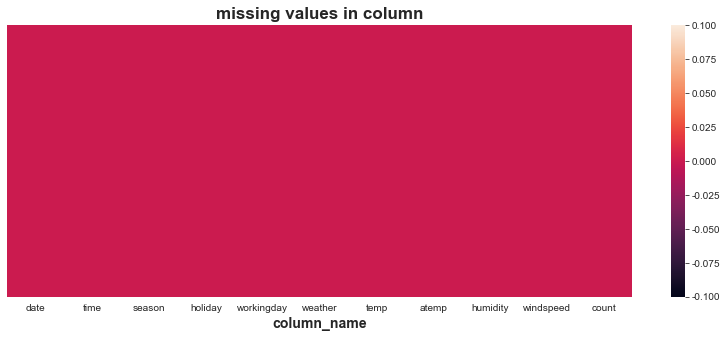

In [38]:
plt.figure(figsize = (14, 5))
sns.heatmap(df.isnull(), cbar = True, yticklabels = False)
plt.xlabel("column_name", size = 14, weight = "bold")
plt.title("missing values in column", fontweight = "bold", size = 17)

plt.show()

Missing values not present

In [39]:
df.head()

,date,time,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01,2022-08-03 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16.0
1,2011-01-01,2022-08-03 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40.0
2,2011-01-01,2022-08-03 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32.0
3,2011-01-01,2022-08-03 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13.0
4,2011-01-01,2022-08-03 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1.0


### Split data, time column

In [40]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek

df["hour"] = df["time"].dt.hour

In [41]:
df = df.drop(columns = ['date', 'time'], axis = 1)

In [42]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,dayofweek,hour
0,1,0,0,1,9.84,14.395,81,0.0,16.0,2011,1,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,40.0,2011,1,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32.0,2011,1,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,13.0,2011,1,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1.0,2011,1,1,5,4


1. <br>
'holiday' feature should be removed<br>
January 1st is a day off.<br>
But, this table shows 0 value in the holiday col.<br>
Of course it was 0 value in the workingday col.

I think the holiday column only indicates whether it is a regular weekend<br>
except public holiday including substitute holiday.

Therefore, the workingday column is judged to be more accurate data<br>
than the holiday column showing only weekend.


2. <br>
dayofweek explanation<br>
0 = mon<br>
1 = tue<br>
2 = wed<br>
3 = thu<br>
4 = fri<br>
5 = sat<br>
6 = sun

# EDA

### HeatMap
Check the correlation between variables

<AxesSubplot:>

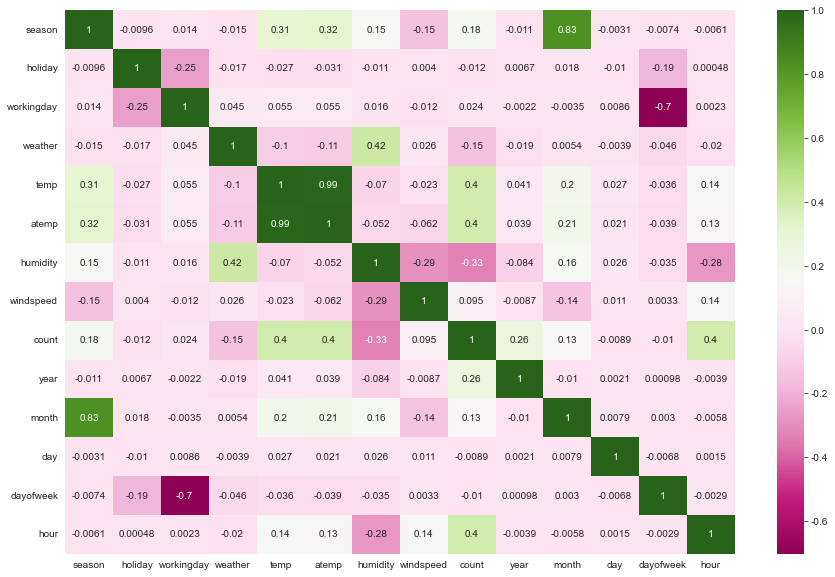

In [43]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), cmap = 'PiYG', annot = True)

##### Multicollinearity
1. temp & atemp<br>
'temp & atemp' are highly correlated.<br>
Since temp is more objective data than atemp, <br>
so atemp will be removed.<br>


2. season & month
'season & month' are also highly correlated.<br>
'season' column is easier to see than month,<br>
so month will be removed.

#### Correlation between dependent and independent variables
These independent variables are highly correlated with 'count'<br>
1. temp & atemp<br>
2. year<br>
3. hour

### Feature Categorization

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   holiday     17379 non-null  int64  
 2   workingday  17379 non-null  int64  
 3   weather     17379 non-null  int64  
 4   temp        17379 non-null  float64
 5   atemp       17379 non-null  float64
 6   humidity    17379 non-null  int64  
 7   windspeed   17379 non-null  float64
 8   count       17379 non-null  float64
 9   year        17379 non-null  int64  
 10  month       17379 non-null  int64  
 11  day         17379 non-null  int64  
 12  dayofweek   17379 non-null  int64  
 13  hour        17379 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 1.9 MB


'season', 'holiday', 'workingday', 'weather', <br>
'year', 'month', 'day', 'weekend', 'hour' <br>
<b>The above data are categorical types.<b>

So, the data of int64 should be changed to category type.

### Check the VIF value

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
 
   # Calculating VIF
   vif = pd.DataFrame()
   vif["variables"] = X.columns
   vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
 
   return(vif)

In [46]:
# Excpet dependent varaubale

calc_vif(df[[i for i in df.describe().columns 
                if i not in ['count'] ]])

,variables,VIF
0,season,21.386386
1,holiday,1.543265
2,workingday,8.976866
3,weather,7.639762
4,temp,335.879862
5,atemp,381.761436
6,humidity,17.518428
7,windspeed,4.090190
8,year,64.960019
9,month,15.161339


Remove 'atemp', 'month', 'holiday' column<br>

In [47]:
calc_vif(df[[i for i in df.describe().columns 
                if i not in ['count', 'atemp', 'month', 'holiday'] ]])

,variables,VIF
0,season,7.092216
1,workingday,6.241530
2,weather,7.622385
3,temp,8.825919
4,humidity,17.389835
5,windspeed,3.889881
6,year,51.446222
7,day,4.194912
8,dayofweek,6.451194
9,hour,4.238645


'humidity' and 'weather' are correlated by looking at the heatmap,<br>
but these two variables are irreplaceable.

'year' should not be deleted<br>
because it tells us that the demand for bicycle rental is<br>
increasing every year.

So, I will not delete these coulmns.

### Barplot

'year, month, day, hour & count' Visualization

[Text(0.5, 0, 'Hour'), Text(0.5, 1.0, 'Hourly rental volumn')]

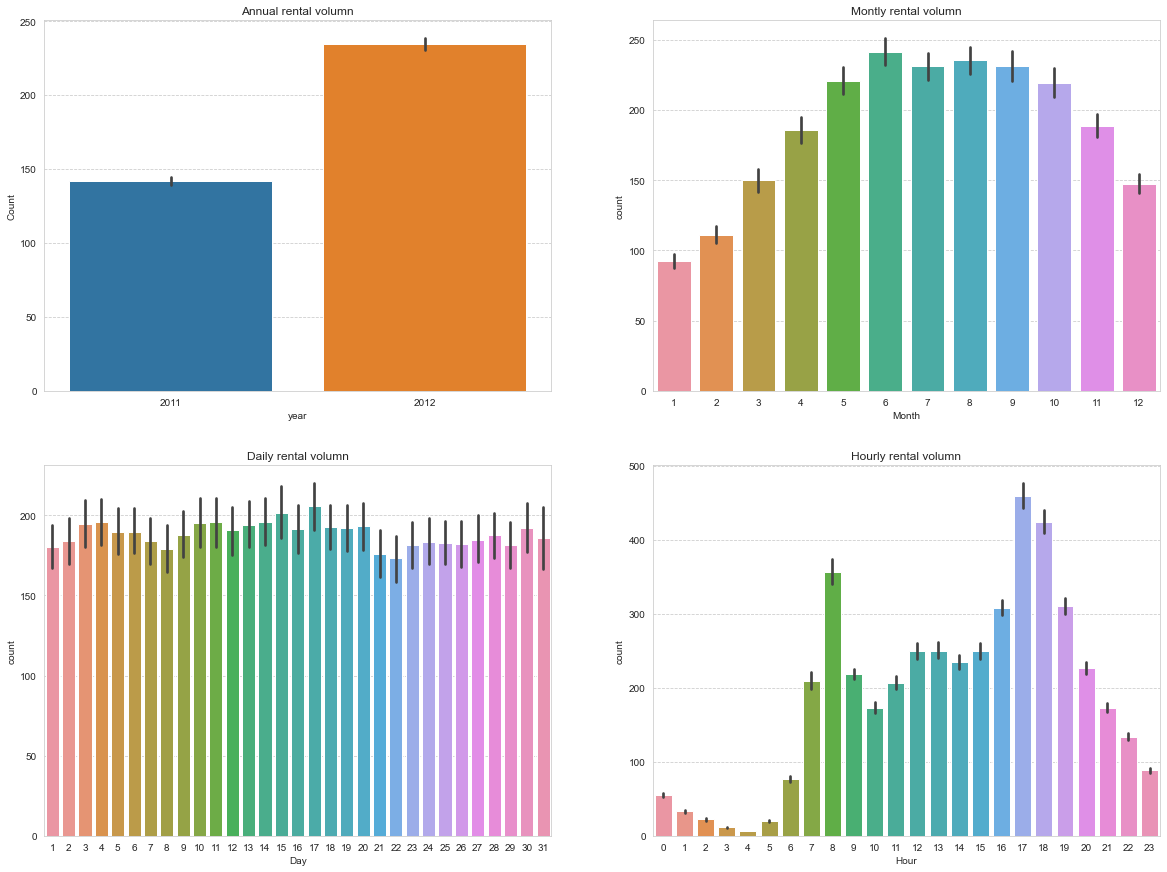

In [48]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(20, 15)

sns.barplot(data = df, x = "year", y = "count", ax = ax1)
sns.barplot(data = df, x = "month", y = "count", ax = ax2)
sns.barplot(data = df, x = "day", y = "count", ax = ax3)
sns.barplot(data = df, x = "hour", y = "count", ax = ax4)

ax1.set(ylabel = 'Count', title = "Annual rental volumn")
ax2.set(xlabel = 'Month', title = "Montly rental volumn")
ax3.set(xlabel = 'Day', title = "Daily rental volumn")
ax4.set(xlabel='Hour', title = "Hourly rental volumn")

##### Annual rental volumn
Compared to the previous year, <br>
the count is gradually increasing.

##### Monthly rental volumn
Large count : June ~ October<br>
Low count : December ~ March
    
The largest rental volume : June, September<br>
The smallest rental volume : January, Feburary
    
##### Daily rental volumn
There is not much difference by day, and<br>
no noticeable event at the beginning fo the month or<br>
at the end of the month.

##### hourly rental volumn
Large count : 7 a.m. ~ 8 p.m.<br>
Especially high count : rush hour (7 ~ 9AM, 5 ~ 7PM)

Low count : Early morning hours (12 ~ 6AM)

### Boxplot

'season, holiday, workingday, weather & count' Visualization

[Text(0.5, 0, 'Weather'), Text(0.5, 1.0, 'Weather rental volumn')]

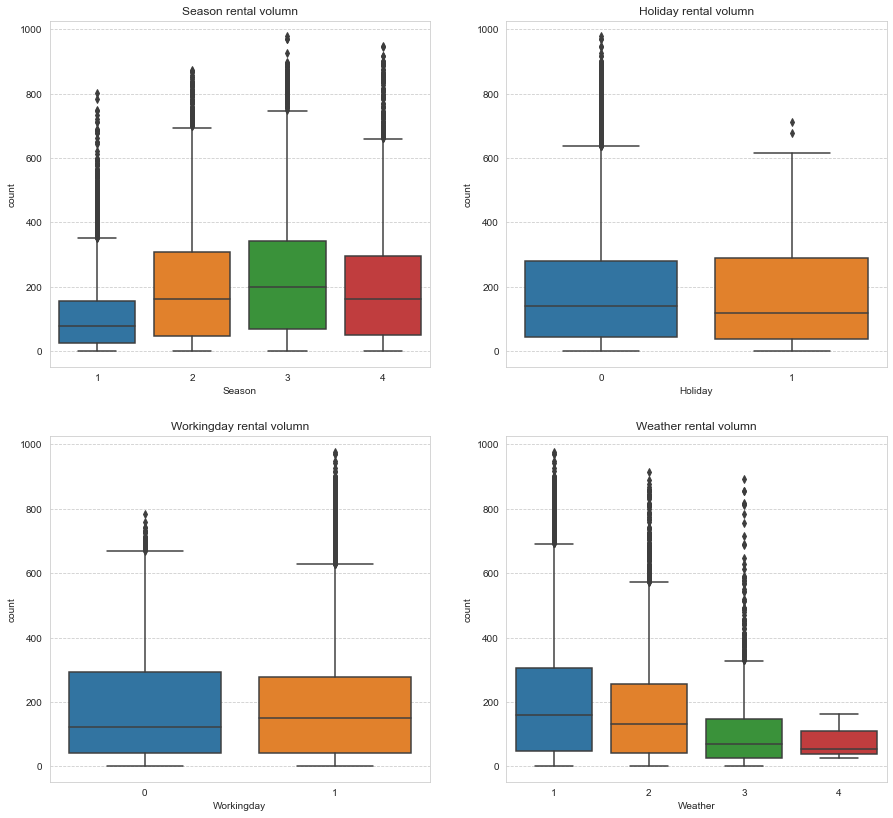

In [49]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(15, 14)

sns.boxplot(data = df, y = "count", x = "season", orient = "v", ax = axes[0][0])
sns.boxplot(data = df, y = "count", x = "holiday", orient = "v", ax = axes[0][1])
sns.boxplot(data = df, y = "count", x = "workingday", orient = "v", ax = axes[1][0])
sns.boxplot(data = df, y = "count", x = "weather", orient = "v", ax = axes[1][1])

axes[0][0].set(xlabel = 'Season', title = "Season rental volumn")
axes[0][1].set(xlabel = 'Holiday', title = "Holiday rental volumn")
axes[1][0].set(xlabel = 'Workingday', title = "Workingday rental volumn")
axes[1][1].set(xlabel = 'Weather', title = "Weather rental volumn")

##### Season rental volumn
1 (spring), 2 (summer), 3 (autumn), 4 (winter)<br>
summer, autumn > spring, winter

##### Holiday rental volumn & Workingday rental volumn
By a narrow margin, holiday > workingday

##### Weather rental volumn
1 (clean), 2 (cloudy), 3 (light snow&rain), 4 (heavy snow&rain)<br>
count : 1 > 2 > 3 > 4

Those who rented bicycles in heavy snow and rainy weather may be people<br>
with urgent circumstances.<br>
They are really a few.<br>
So this is unusual, and it needs to be removed.

∴ Overall, there seems to be a lot of outliers.<br>
&nbsp;&nbsp;&nbsp;&nbsp;We need to get rid of outliers.

### Pointplot

'hour, workingday, dayofweek, weather, season & count' Visualization

[Text(0.5, 0, 'Season'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Season rental volumn')]

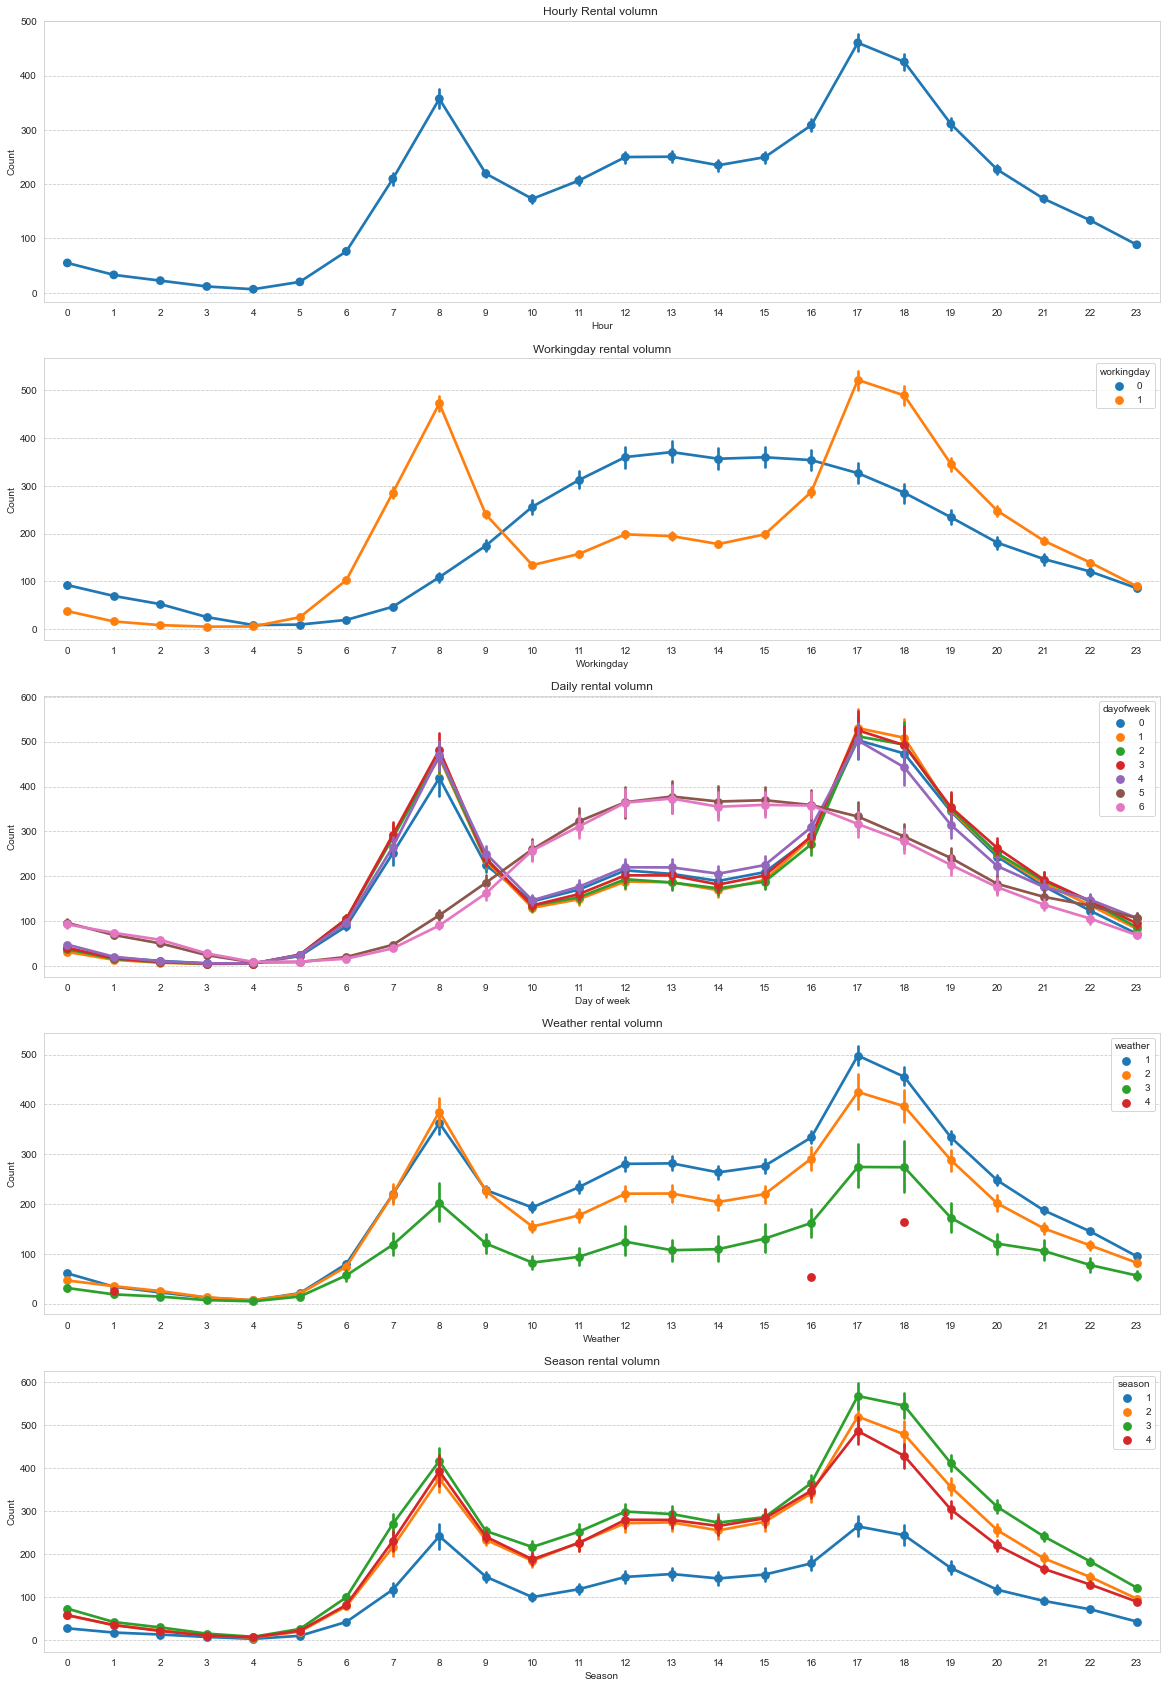

In [50]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5)
fig.set_size_inches(20, 30)

sns.pointplot(data = df, x = "hour", y = "count", ax = ax1)
sns.pointplot(data = df, x = "hour", y = "count", hue = "workingday", ax = ax2)
sns.pointplot(data = df, x = "hour", y = "count", hue = "dayofweek", ax = ax3)
sns.pointplot(data = df, x = "hour", y = "count", hue = "weather", ax = ax4)
sns.pointplot(data = df, x = "hour", y = "count", hue = "season", ax = ax5)

ax1.set(xlabel = 'Hour', ylabel = 'Count', title = "Hourly Rental volumn ")
ax2.set(xlabel = 'Workingday', ylabel = 'Count', title = "Workingday rental volumn")
ax3.set(xlabel = 'Day of week', ylabel = 'Count', title = "Daily rental volumn")
ax4.set(xlabel='Weather', ylabel = 'Count', title = "Weather rental volumn")
ax5.set(xlabel='Season', ylabel = 'Count', title = "Season rental volumn")

##### Workingday rental volumn & Daily rental volumn
Highest rental volumn <br>
working day : rush hour (7 - 9AM, 4 - 7PM)<br>
Holiday : late morning to late afternoon (10AM - 7PM)

##### Weather rental volumn
Highest : Clear & Cloudy<br>
Small count : Small snow & rain<br>
Outlier : heavy snow & rain<br>
(→ have to delete)

##### Season rental volumn
Highest : Summer, Autumn<br>
Smallest : Spring

# Regplot (산점도)

'temp, windspeed, humidity' Visualization

<AxesSubplot:xlabel='humidity', ylabel='count'>

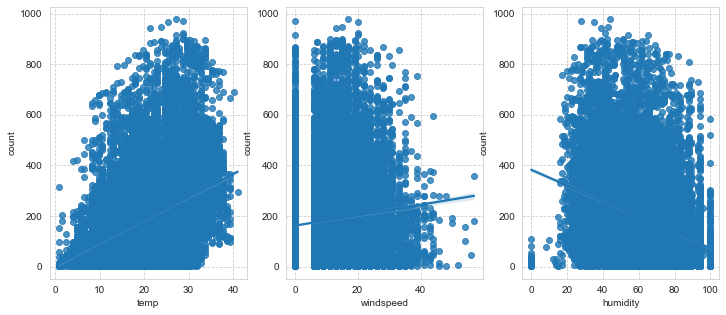

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(12, 5)

sns.regplot(x = "temp", y = "count", data = df, ax = ax1)
sns.regplot(x = "windspeed", y = "count", data = df, ax = ax2)
sns.regplot(x = "humidity", y = "count", data = df, ax = ax3)

##### temp
Highest: the medium temperature<br>
'temp' is directly proportional to 'count'

##### windspeed
'windspeed' is just a little bit of directly proportional to 'count'<br>
There's almost no rental if it's over 40m/s

A large number of zero value<br>
→ Determined by missing value<br>
→ Have to feature engineering (predict 0 value)

##### Humidity
'humidity' is inversely proportional to 'count'

# Feature Engineering

### Visualize the 'count' distribution plot

<AxesSubplot:xlabel='count', ylabel='Density'>

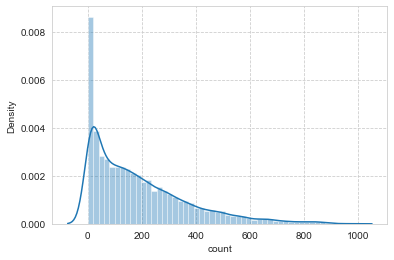

In [52]:
sns.distplot(df['count'])

The distribution of 'count' is skewed to the left.<br>
Must be normalized.

0.2777125698863726


<AxesSubplot:xlabel='count', ylabel='Density'>

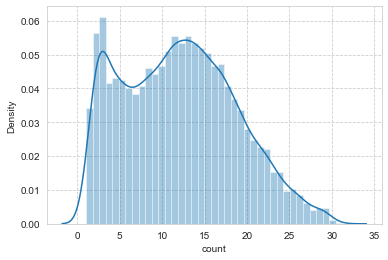

In [53]:
df_root = np.sqrt(df['count'])
#루트 변환

print(df_root.skew())
#skewness(왜도) 확인

sns.distplot(df_root)

### Feature Categorization

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   holiday     17379 non-null  int64  
 2   workingday  17379 non-null  int64  
 3   weather     17379 non-null  int64  
 4   temp        17379 non-null  float64
 5   atemp       17379 non-null  float64
 6   humidity    17379 non-null  int64  
 7   windspeed   17379 non-null  float64
 8   count       17379 non-null  float64
 9   year        17379 non-null  int64  
 10  month       17379 non-null  int64  
 11  day         17379 non-null  int64  
 12  dayofweek   17379 non-null  int64  
 13  hour        17379 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 1.9 MB


'season', 'holiday', 'workingday', 'weather',<br>
'year', 'month', 'day', 'dayofweek', 'hour'
→ Categorical features are in the numerical type

Therefore, the types of these columns should be changed to categorical types.

In [55]:
categorical_feature = ["season", "holiday", "workingday", "weather",
                            "year", "month", "day", "dayofweek", "hour"]

for var in categorical_feature :
    df[var] = df[var].astype("category")

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   holiday     17379 non-null  category
 2   workingday  17379 non-null  category
 3   weather     17379 non-null  category
 4   temp        17379 non-null  float64 
 5   atemp       17379 non-null  float64 
 6   humidity    17379 non-null  int64   
 7   windspeed   17379 non-null  float64 
 8   count       17379 non-null  float64 
 9   year        17379 non-null  category
 10  month       17379 non-null  category
 11  day         17379 non-null  category
 12  dayofweek   17379 non-null  category
 13  hour        17379 non-null  category
dtypes: category(9), float64(4), int64(1)
memory usage: 835.3 KB


### Outlier (weather)

In [59]:
# Check the types of data in the weather column using unique

df['weather'].unique()

[1, 2, 3, 4]
Categories (4, int64): [1, 2, 3, 4]

In [60]:
# Count the number of data for each type of weather column using value_counts

df['weather'].value_counts()

1    11413
2     4544
3     1419
4        3
Name: weather, dtype: int64

There are a total of 3 data of 'Heavy snow & rain'.<br>
So, they are ouliers.

I guess that those who used the bicycle in heavy snowy and rainy weather<br>
had very urgent business.

These data are not general reasons for bicycle use,<br>
so I'll consider them as oulier and remove them.

In [63]:
# Remove 3 peice of data in weather column's 4(heavy snow & rain)

df= df[df.weather != 4 ]
df['weather'].value_counts()

1    11413
2     4544
3     1419
4        0
Name: weather, dtype: int64

### Remove Outliers

Remove data that is too close to zero or too far end

In [65]:
dfWithoutOutliers = df[np.abs(df["count"] - df["count"].mean()) <= (3*df["count"].std())]

print(df.shape)
print(dfWithoutOutliers.shape)

# The result number of data  : 17376 -> 17124

(17376, 14)
(17124, 14)


((array([-3.94155643, -3.72346947, -3.60405038, ...,  3.60405038,
          3.72346947,  3.94155643]),
  array([ 1.        ,  1.        ,  1.        , ..., 26.90724809,
         26.90724809, 26.90724809])),
 (6.279561029393282, 11.787814675717687, 0.9862461179261298))

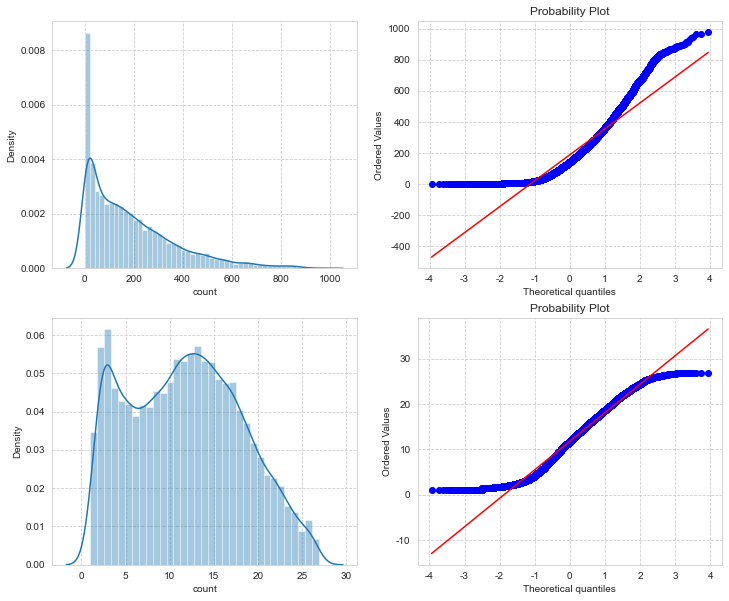

In [67]:
# Compare Original data with Remove outliers data (sqrt)
# Understand the data distribution of count values

from scipy import stats

figure, axes = plt.subplots(ncols = 2, nrows = 2)
figure.set_size_inches(12, 10)

sns.distplot(df["count"], ax = axes[0][0])
stats.probplot(df["count"], dist = 'norm', fit = True, plot = axes[0][1])
sns.distplot(np.sqrt(dfWithoutOutliers["count"]), ax = axes[1][0])
stats.probplot(np.sqrt(dfWithoutOutliers["count"]), dist = 'norm', fit = True, plot = axes[1][1])

### Modeling the zero value prediction of the 'windspeed' feature

Predict 0 value using randomforest model

In [68]:
# Count a total 'windspeed' data

df['windspeed'].count()

17376

In [69]:
# Count 0 value in 'windspeed' col

len(df.loc[df['windspeed'] == 0])

2180

In [70]:
# Percentage of 0 value among windspeed row data

print ('%.2f%%' % (2180.0 / 17376.0 * 100.0))

12.55%


<AxesSubplot:title={'center':'Original windspeed distribution'}, xlabel='windspeed', ylabel='count'>

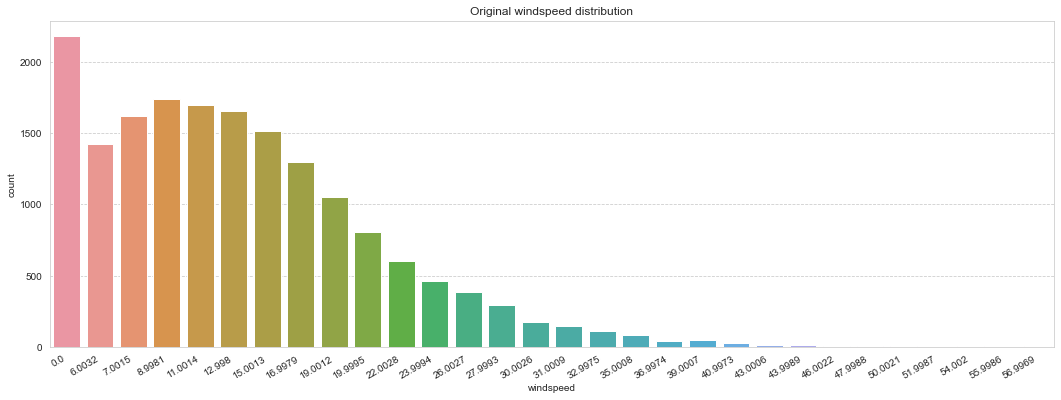

In [71]:
# Visualize the windspeed col distribution plot of dataframe 
# before 0 value prediction modeling

fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation = 30, ha = 'right')
ax1.set(ylabel = 'Count', title = "Original windspeed distribution")
sns.countplot(data = df, x = "windspeed", ax = ax1)

In [72]:
# Split windspeed into zero and non-zero values

dfWind0 = df.loc[df['windspeed'] == 0]
dfWindNot0 = df.loc[df['windspeed'] != 0]

print(dfWind0.shape)
print(dfWindNot0.shape)

(2180, 14)
(15196, 14)


In [73]:
# Create 0 value prediction model

from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # split windspeed into zero and non-zero values
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # select features to predict 0 values in windspeed col
    wCol = ["season", "weather", "humidity", "hour", "temp", "year"]

    # windspeed != 0 data type → convert to string
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # Use randomforest model
    rfModel_wind = RandomForestClassifier()

    # Windspeed learning using wCol
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # Predict 0 values in windspeed feature
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # To compare to the old one after completing the value prediction,
    # create a dataframe to include predictions
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # windspeed = 0 → Put the predicted value
    predictWind0["windspeed"] = wind0Values

    # Merge dataWindNot0 and dataWind0 
    data = predictWindNot0.append(predictWind0)

    # windspeed datatype => float 
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace = True)
    data.drop('index', inplace = True, axis = 1)
    
    return data

In [75]:
# Adjust the 0 value

df = predict_windspeed(df)

<AxesSubplot:title={'center':'Final windspeed distribution'}, xlabel='windspeed', ylabel='count'>

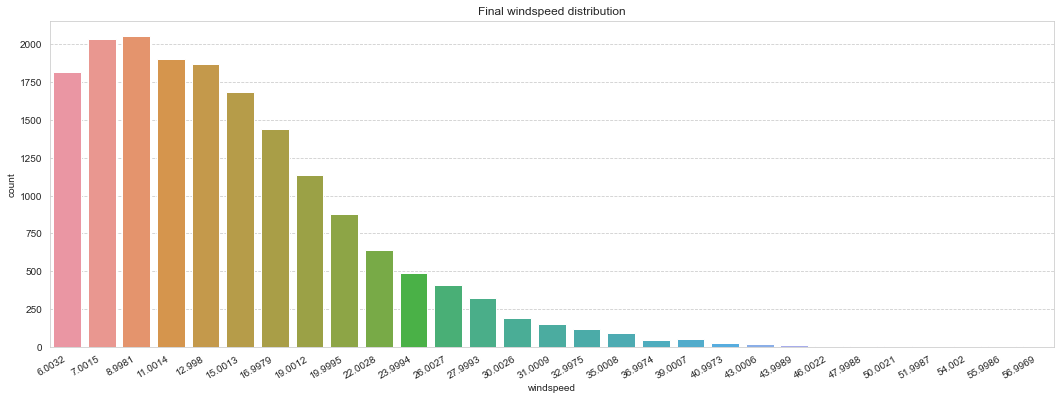

In [76]:
# Visualize windspeed distribution plot after 0 value modeling

fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation = 30, ha = 'right')
ax1.set(ylabel='Count', title = "Final windspeed distribution")
sns.countplot(data = df, x = "windspeed", ax = ax1)

I've heard that in the field of practice,<br>
they don't predict small parts using modeling to finally predict the model well.

This is just a prediction for kaggle submission.

In order to predict a model in the field other than the kaggle version,<br>
I think it is necessary to remove the windspeed col or<br>
find another way.

### Feature drop (unuseful feature)

holiday : Can be replaced by 'workingday'<br>
atemp : It shows multicollinearity with 'temp', and is less objective than that<br>
month : Can be relaced by 'season'<br>
day : Can be replaced by 'workingday' and no special events related to <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;the end of the month and the beginning of the month<br>
dayofweek : Can be replaced by 'workingday'

In [77]:
df.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
count          float64
year          category
month         category
day           category
dayofweek     category
hour          category
dtype: object

In [78]:
drop_features = ['holiday', 'atemp', 'month', 'day', 'dayofweek']

df = df.drop(drop_features, axis = 1)

In [79]:
df.dtypes

season        category
workingday    category
weather       category
temp           float64
humidity         int64
windspeed      float64
count          float64
year          category
hour          category
dtype: object

### Hot Encoding

season, workingday, weather, year, hour → category type

Create dummy variable in order to modeling

In [80]:
#season

season_encoded = pd.get_dummies(df['season'], prefix = 'season')
df = pd.concat((df,season_encoded), axis = 1)
df = df.drop(columns = 'season')

In [81]:
#workingday

workingday_encoded = pd.get_dummies(df['workingday'], prefix = 'workingday')
df = pd.concat((df,workingday_encoded), axis = 1)
df = df.drop(columns = 'workingday')

In [82]:
#weather

weather_encoded = pd.get_dummies(df['weather'],prefix = 'weather')
df = pd.concat((df,weather_encoded), axis = 1)
df = df.drop(columns = 'weather')

In [83]:
#year

year_encoded = pd.get_dummies(df['year'], prefix = 'year')
df = pd.concat((df,year_encoded), axis = 1)
df = df.drop(columns = 'year')

In [84]:
#hour

hour_encoded = pd.get_dummies(df['hour'], prefix = 'hour')
df = pd.concat((df,hour_encoded), axis = 1)
df = df.drop(columns = 'hour')

In [85]:
df.dtypes

temp            float64
humidity          int64
windspeed       float64
count           float64
season_1          uint8
season_2          uint8
season_3          uint8
season_4          uint8
workingday_0      uint8
workingday_1      uint8
weather_1         uint8
weather_2         uint8
weather_3         uint8
weather_4         uint8
year_2011         uint8
year_2012         uint8
hour_0            uint8
hour_1            uint8
hour_2            uint8
hour_3            uint8
hour_4            uint8
hour_5            uint8
hour_6            uint8
hour_7            uint8
hour_8            uint8
hour_9            uint8
hour_10           uint8
hour_11           uint8
hour_12           uint8
hour_13           uint8
hour_14           uint8
hour_15           uint8
hour_16           uint8
hour_17           uint8
hour_18           uint8
hour_19           uint8
hour_20           uint8
hour_21           uint8
hour_22           uint8
hour_23           uint8
dtype: object

### Feature Selection

In [86]:
features_name = ["temp", "humidity", "windspeed",
                 "season_1", "season_2", "season_3", "season_4",
                 "workingday_0", "workingday_1",
                 "weather_1", "weather_2", "weather_3", "weather_4",
                "year_2011", "year_2012", "hour_0", "hour_1", "hour_2",
                 "hour_3", "hour_4", "hour_5", "hour_6", "hour_7",
                 "hour_8", "hour_9", "hour_10", "hour_11", "hour_12",
                 "hour_13", "hour_14", "hour_15", "hour_16", "hour_17",
                "hour_18", "hour_19", "hour_20", "hour_21",
                 "hour_22", "hour_23"]

features_name

['temp',
 'humidity',
 'windspeed',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'workingday_0',
 'workingday_1',
 'weather_1',
 'weather_2',
 'weather_3',
 'weather_4',
 'year_2011',
 'year_2012',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23']

# Selection of evaluation indicators 

In [87]:
#creating list of matrix to store the evaluation matrix of all model

mean_sq_error = []
root_mean_sq_error = []
r2_list = []
adj_r2_list = []

**MSE (Mean Squared Error)**<br>
It's sensitive to outliers.<br>
The closer it's to 0 value, the better the performance of the model.

**RMSE (Root Mean Squared Error)**<br>
Since it's less sensitive to errors of large differences but<br>
depends on the size of the actual value,<br>
a size-dependent error may occur.

The closer it's to 0 value, the better the performance of the model.

**R2 (R-Squared)**<br>
It is relatively possible to judge the performance of the model.<br>
As the independent variable is added, the value of r2 increases.

The closer the model is to 1, the higher the performance of the model

**Adj R2 (Adjusted R2)**<br>
The value of adjr2 increases only when you add useful independent variables.

The closer the model is to 1, the higher the performance of the model

# Functions

Train linear models and create functions that calculate scores

In [88]:
# making a function to train and evaluate linear model
def train_linear_model (model, X_train, y_train, X_test, y_test):

#training the model
  model.fit(X_train, y_train)

  #predicting the values
  pred = model.predict(X_test)
  import math
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

  print('\n================Evalution Matrix=========================\n')

  #finding mean_squared_error
  MSE  = mean_squared_error(y_test ** 2, pred ** 2)
  print("MSE :" , MSE)

  #finding root mean squared error
  RMSE = np.sqrt(MSE)
  print("RMSE :" , RMSE)

  #finding the r2 score
  r2 = r2_score(y_test ** 2, pred ** 2)
  print("R2 :" , r2)
  #finding the adjusted r2 score
  adj_r2 = 1 - (1 - r2_score(y_test ** 2, pred ** 2)) * ((X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
  print("Adjusted R2 : ", adj_r2)
  

#appending metrice to list
  mean_sq_error.append(MSE)
  root_mean_sq_error.append(RMSE)
  r2_list.append(r2)
  adj_r2_list.append(adj_r2)
    
  # ploting the line graph of actual and predicted values
  print('\
  =========================================================\
  Model Graph\
  ===================================================\n')  
  plt.figure(figsize = (20,10))
  plt.plot((pred)[:100])
  plt.plot((np.array(y_test)[:100]))
  plt.legend(["Predicted", "Actual"])
    
  plt.show()

Create a function that runs another model

In [89]:
def run_model(model, X_train, y_train, X_test, y_test):
    
    # Fit Model
    model.fit(X_train, y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    import math
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score
    print('\n================Evalution Matrix=========================\n')
    MSE  = mean_squared_error(y_test, preds)
    print("MSE :" , MSE)
    
    RMSE = np.sqrt(MSE)
    print("RMSE :" , RMSE)
    r2 = r2_score(y_test, preds)
    print("R2 :" , r2)
    adj_r2 = 1 - (1 - r2_score(y_test, preds)) * ((X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
    print("Adjusted R2 : ", adj_r2)

    train_class_preds = linear_model.predict(X_train)
    

    mean_sq_error.append(MSE)
    root_mean_sq_error.append(RMSE)
    r2_list.append(r2)
    adj_r2_list.append(adj_r2)

    #ploting 
    print('\
    =========================================================\
    Model Graph\
    ===================================================\n') 
    plt.figure(figsize = (20,10))
    plt.plot(np.array(y_test[:100]))
    plt.plot(preds[:100])    
    plt.legend(["ACTUAL", "PREDICTED"], prop = {'size': 20})
    plt.show()

# Modeling

##### 1. Model
- Linear Regression
- Ridge
- Lasso
- ElasticNet
- RandomForest
- GradientBoost
- XGBoost (Extreme Gradient Boosting)
- Catboost
- LightGBM

##### 2. Cross Validation
- Using GridSearchCV

In [91]:
#pip install lime

##### lime(Local Interpretable Model-agnostic Explanation) tablular

1. LIME : model agnostic한 XAI 알고리즘, 모델 종류 무관하게 적용 가능<br>
2. tabular 데이터 뿐만 아니라 이미지, 자연어 등 다양한 데이터 타입 받아들임<br>
3. 모델의 지역적인 결정경계에 선형 모델과 같은 glassbox 알고리즘 학습시킴.<br>
   -> 모델 : 대리 모델(surrogate model), 대리 모델의 계수 사용해 설명 가능성 제공

In [92]:
# LIME SECTION

import lime
import lime.lime_tabular
def LimeTabularExplainer_table(model, instance,num_features, dependent_var):
  
  # vaariable to store feature names
  # X=df.drop(dependent_var,axis=1)
  # feature_names =list(X.columns)
    
  X = X_test
  feature_names = list(X_test.columns)

  explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names = feature_names, mode = 'regression')

  # selecting the instace to explain
  choosen_instance = X.reset_index(drop = True).loc[[instance]].values[0]
  exp = explainer.explain_instance(choosen_instance, model.predict, num_features = num_features)
  exp.show_in_notebook(show_table = True)

##### Train, Test Split for Linear Regresseion

In [95]:
# Train - Spliting  data

X = df.drop(['count'], axis = 1)

In [96]:
X.shape

(17376, 39)

In [97]:
y = np.sqrt(df['count'])

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [99]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

### Linear Regresseion


================Evalution Matrix=========================

MSE : 8546.425345853668
RMSE : 92.44687850789592
R2 : 0.7304373819147683
Adjusted R2 :  0.7279947838419699
  =========================================================  Model Graph  ===================================================



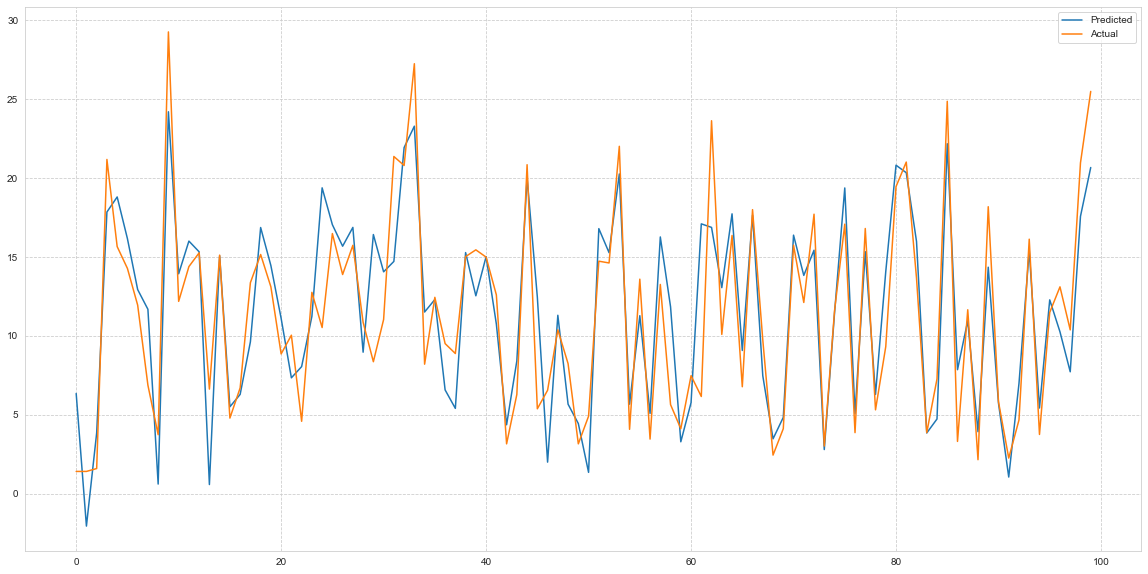

In [100]:
from sklearn.linear_model import LinearRegression

linear_model= LinearRegression()
train_linear_model(linear_model, X_train, y_train, X_test, y_test)

### Ridge

In [101]:
from sklearn.linear_model import Ridge
ridge = Ridge()

# finding the best parameters for ridge model by gridsearchcv

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 60, 100, 0.5, 1.5, 1.6, 1.7, 1.8, 1.9]}
ridge_grid = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 3)  


================Evalution Matrix=========================

MSE : 8528.678617091628
RMSE : 92.35084524297342
R2 : 0.7309971311050967
Adjusted R2 :  0.7285596051090695
  =========================================================  Model Graph  ===================================================



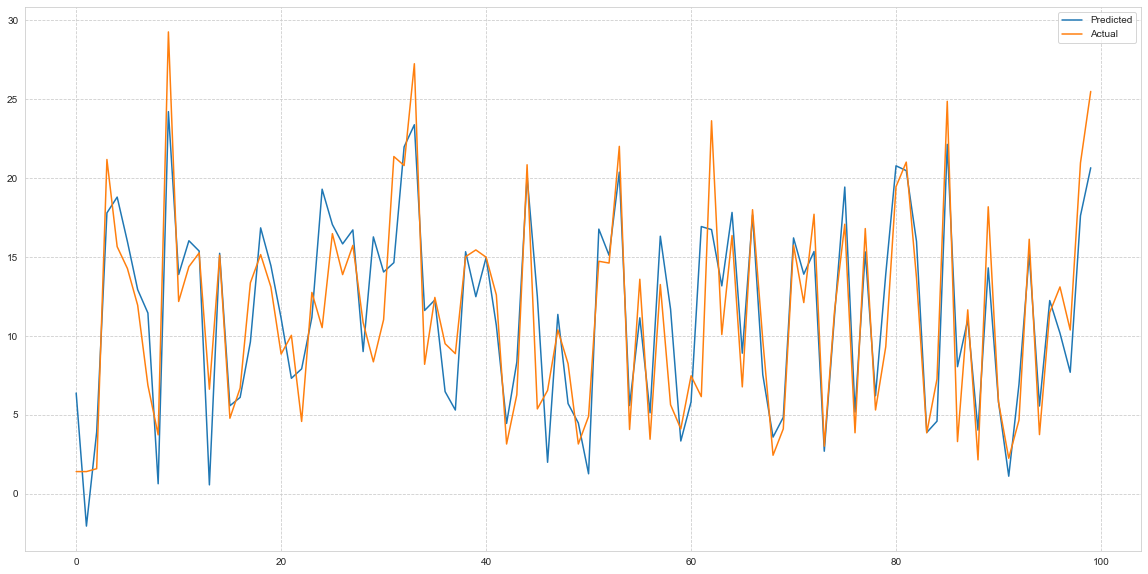

In [102]:
train_linear_model(ridge_grid, X_train, y_train, X_test, y_test)

### Lasso


================Evalution Matrix=========================

MSE : 8526.931514125987
RMSE : 92.34138570611763
R2 : 0.7310522364421732
Adjusted R2 :  0.7286152097742468
  =========================================================  Model Graph  ===================================================



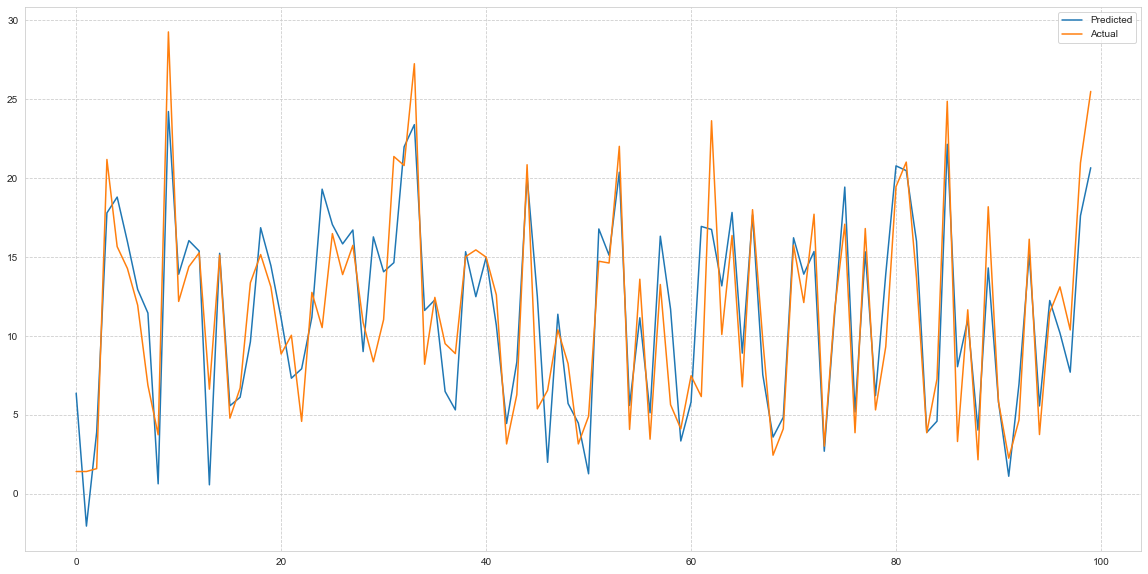

In [103]:
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV
lasso_model = Lasso()
#setting the parameters of the lasso model
parameters = {'alpha': [1e-15, 1e-13, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60, 100, 0.0014]}
lasso_grid = GridSearchCV(lasso_model, parameters, scoring = 'neg_mean_squared_error', cv = 5)

train_linear_model(lasso_grid, X_train, y_train, X_test, y_test)

### ElasticNet Regression


================Evalution Matrix=========================

MSE : 8525.827798284641
RMSE : 92.33540923331981
R2 : 0.7310870487197951
Adjusted R2 :  0.7286503374976929
  =========================================================  Model Graph  ===================================================



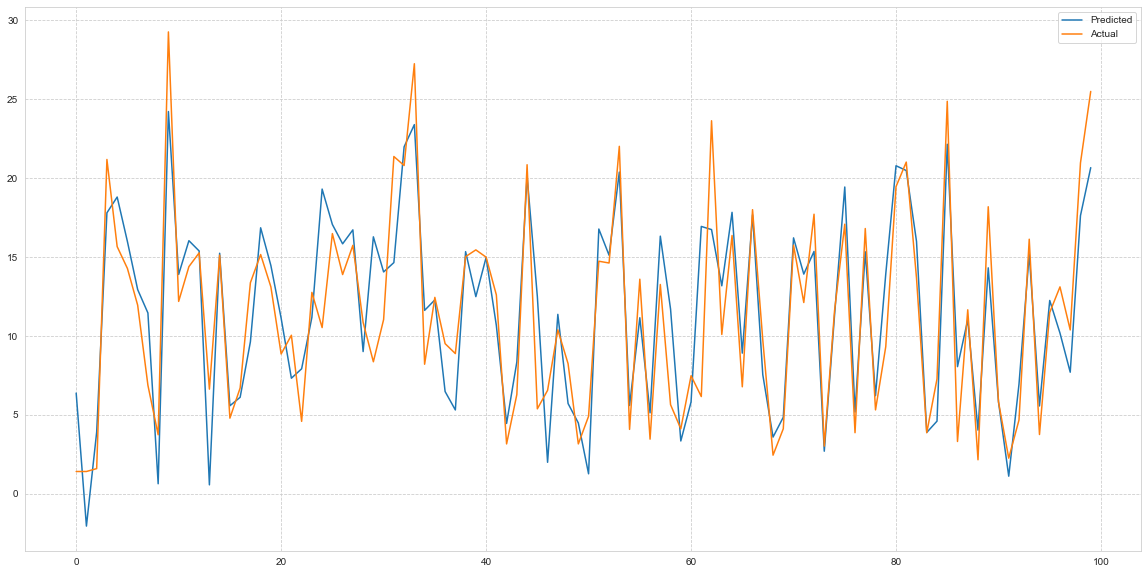

In [104]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet()

# finding the best parameters for ridge model by gridsearchcv

parameters = {'alpha': [1e-15, 1e-13, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60, 100], 'l1_ratio':[0.1, 0.2, 0.3, 0.4, 0.5]}
elastic_grid = GridSearchCV(elastic, parameters, scoring = 'neg_mean_squared_error',cv = 5)

# calling train_linear_model to train,fit and evalution of elasticnet model
train_linear_model(elastic_grid, X_train, y_train, X_test, y_test)

### Random Forest


================Evalution Matrix=========================

MSE : 6.572500237742225
RMSE : 2.5636887950260703
R2 : 0.8498558060039194
Adjusted R2 :  0.8484952986698471
    =========================================================    Model Graph    ===================================================



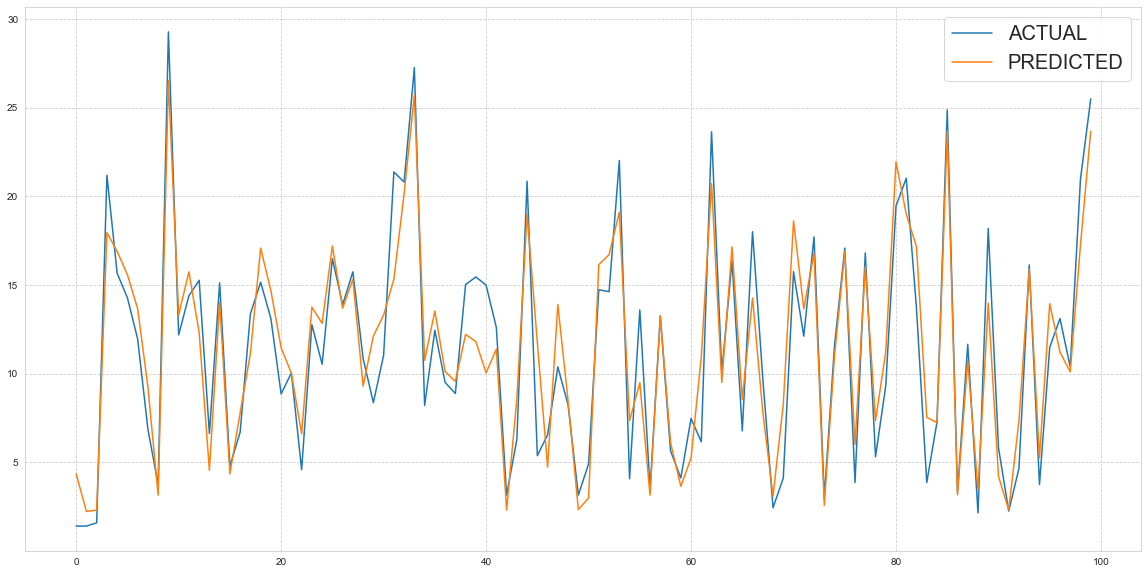

In [105]:
from sklearn.ensemble import RandomForestRegressor

#creating model of random forest
rf_model = RandomForestRegressor()

#creating param dict to check random forest with diffirent value of parameter through gridsearch
n_estimators = [60, 80, 100]
max_depth = [15, 20]
max_leaf_nodes = [40, 60, 80]
params = {'n_estimators' : n_estimators, 'max_depth' : max_depth , 'max_leaf_nodes' : max_leaf_nodes}

#creating rf_grid model to run rf model with gridsearch
rf_grid = GridSearchCV(rf_model, param_grid = params, verbose = 0)

#calling run_model to train,fit and evalution of decision tree model
run_model(rf_grid, X_train, y_train, X_test, y_test)

### Gradient Boosting


================Evalution Matrix=========================

MSE : 1.8605759795318335
RMSE : 1.364029317695127
R2 : 0.9574964365598504
Adjusted R2 :  0.9571112973929903
    =========================================================    Model Graph    ===================================================



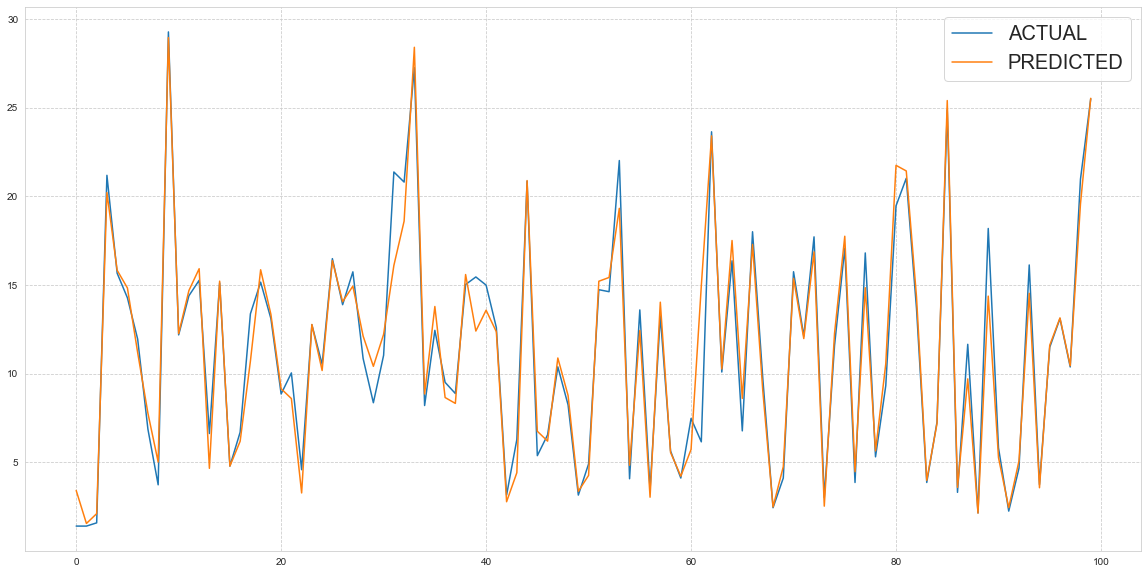

In [107]:
from sklearn.ensemble import GradientBoostingRegressor

#creating model of Gradient Boosting
gb_model = GradientBoostingRegressor()

# creating param dict to check diffirent value of parameter
n_estimators = [80, 100, 150]
max_depth = [15, 20, 30]

params = {'n_estimators' : n_estimators, 'max_depth' : max_depth }

#grid search for gradient bossting
gb_grid = GridSearchCV(gb_model, param_grid = params, verbose = 0)

#calling run_model to train,fit and evalution of gradient boosting model
run_model(gb_grid ,X_train, y_train, X_test, y_test)

### EXtreme Gradient Boosting

In [108]:
# pip install xgboost


================Evalution Matrix=========================

MSE : 1.8646831178091716
RMSE : 1.3655340046330489
R2 : 0.9574026118441448
Adjusted R2 :  0.9570166224997957
    =========================================================    Model Graph    ===================================================



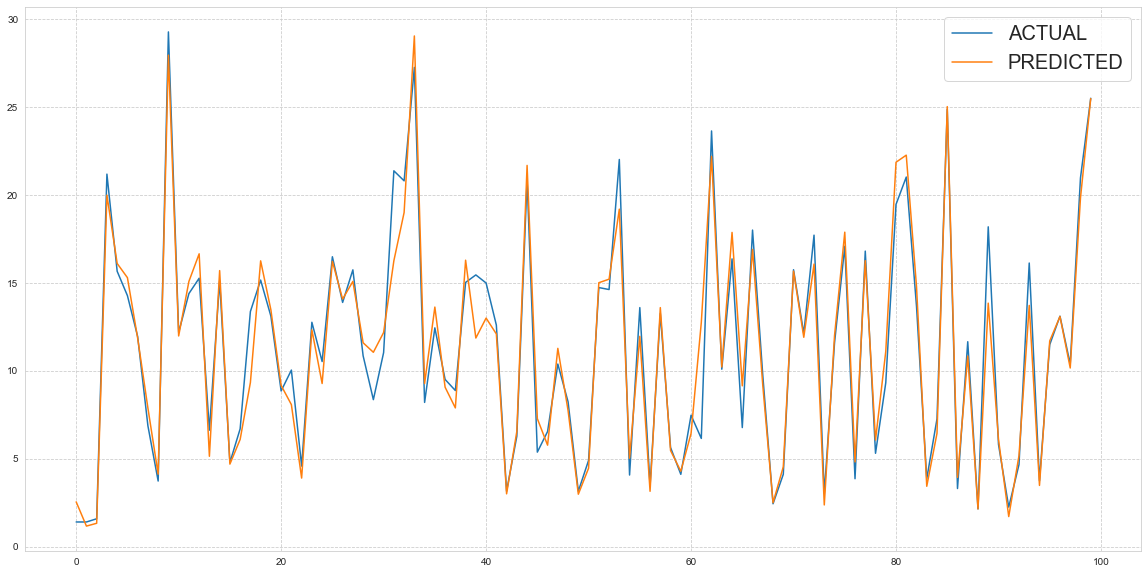

In [109]:
from xgboost import XGBRegressor

#creating Xgboost model
xgb_model = XGBRegressor()

#creating param dict for gridsearch
n_estimators = [80, 100, 150]
max_depth = [15, 20, 30]

params = {'n_estimators' : n_estimators, 'max_depth' : max_depth }

#creating xgb grid model
xgb_grid = GridSearchCV(xgb_model, param_grid = params, verbose = 0)

#calling run_model to train,fit and evalution of xgb_grid model
run_model(xgb_grid, X_train, y_train, X_test, y_test);

### CatBoost

In [110]:
#!pip install catboost


================Evalution Matrix=========================

MSE : 1.6519906251238587
RMSE : 1.2852978740836145
R2 : 0.9622614238225561
Adjusted R2 :  0.9619194618172308
    =========================================================    Model Graph    ===================================================



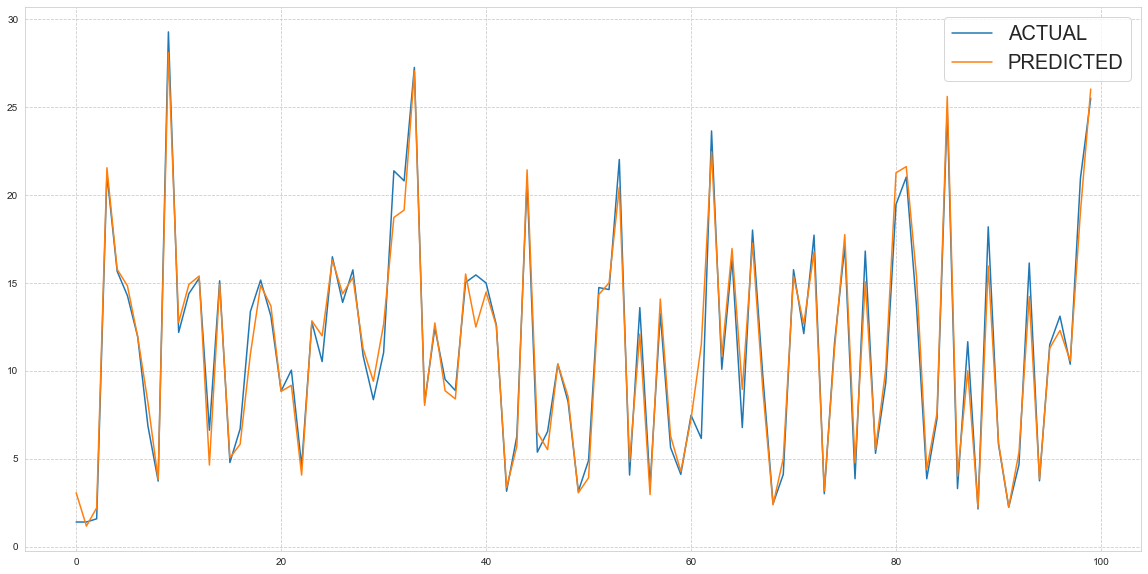

In [111]:
from catboost import CatBoostRegressor

# creating Catboost model
cb_model = CatBoostRegressor(verbose = 0)

#calling run_model to train,fit and evalution of catboost model
run_model(cb_model, X_train, y_train, X_test, y_test)

In [112]:
#checking params of cat boost model
cb_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.06142599880695343,
 'score_function': 'Cosine',
 'task_type'

### lightGBM

In [113]:
#conda install -c conda-forge lightgbm 

Fitting 5 folds for each of 9 candidates, totalling 45 fits

================Evalution Matrix=========================

MSE : 1.7949459178290545
RMSE : 1.339755917258459
R2 : 0.9589957096461701
Adjusted R2 :  0.9586241558999342
    =========================================================    Model Graph    ===================================================



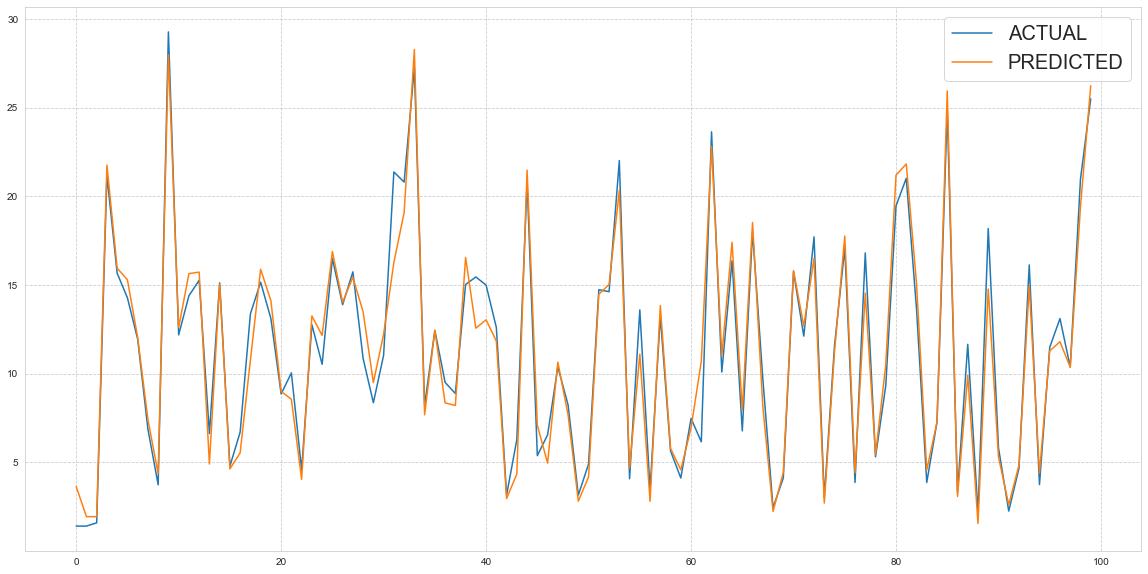

In [114]:
import lightgbm as lgb

lgbr = lgb.LGBMRegressor()

# finding the best parameters for XGBRegressor by gridsearchcv
lgbr_para = {'n_estimators' : [150, 200, 250], 'max_depth' : [7, 10, 13]}
lgbr_grid = GridSearchCV(estimator = lgbr, param_grid = lgbr_para, cv = 5, scoring = 'neg_mean_squared_error', verbose = 5, n_jobs = -1)

#calling run_model to train,fit and evalution of catboost model
run_model(lgbr_grid, X_train, y_train, X_test, y_test)

### Combined Evaluation Matrix of All the models

In [115]:
#creating dictionary to store all the metrices 

all_model_matrices = {'Mean_square_error' : mean_sq_error, 'Root_Mean_square_error' : root_mean_sq_error, 'R2' : r2_list, 'Adjusted_R2' : adj_r2_list}

In [116]:
#list of all model

model_name = ['Linear', 'Lasso', 'Ridge', 'Elasticnet', 'Random_Forest', 'Gradient_Boosting', 'Xtreme_GB', 'CATBoost', 'lightGBM']

In [117]:
#converting dictionary to dataframe fro easy visual

matrices_df = pd.DataFrame.from_dict(all_model_matrices, orient = "index", columns = model_name)

In [118]:
matrices_df

,Linear,Lasso,Ridge,Elasticnet,Random_Forest,Gradient_Boosting,Xtreme_GB,CATBoost,lightGBM
Mean_square_error,8546.425346,8528.678617,8526.931514,8525.827798,6.572500,1.860576,1.864683,1.651991,1.794946
Root_Mean_square_error,92.446879,92.350845,92.341386,92.335409,2.563689,1.364029,1.365534,1.285298,1.339756
R2,0.730437,0.730997,0.731052,0.731087,0.849856,0.957496,0.957403,0.962261,0.958996
Adjusted_R2,0.727995,0.728560,0.728615,0.728650,0.848495,0.957111,0.957017,0.961919,0.958624


In [119]:
matrices_df = matrices_df.transpose().reset_index().rename(columns = {'index' : 'Models'})

In [120]:
matrices_df

,Models,Mean_square_error,Root_Mean_square_error,R2,Adjusted_R2
0,Linear,8546.425346,92.446879,0.730437,0.727995
1,Lasso,8528.678617,92.350845,0.730997,0.728560
2,Ridge,8526.931514,92.341386,0.731052,0.728615
3,Elasticnet,8525.827798,92.335409,0.731087,0.728650
4,Random_Forest,6.572500,2.563689,0.849856,0.848495
5,Gradient_Boosting,1.860576,1.364029,0.957496,0.957111
6,Xtreme_GB,1.864683,1.365534,0.957403,0.957017
7,CATBoost,1.651991,1.285298,0.962261,0.961919
8,lightGBM,1.794946,1.339756,0.958996,0.958624


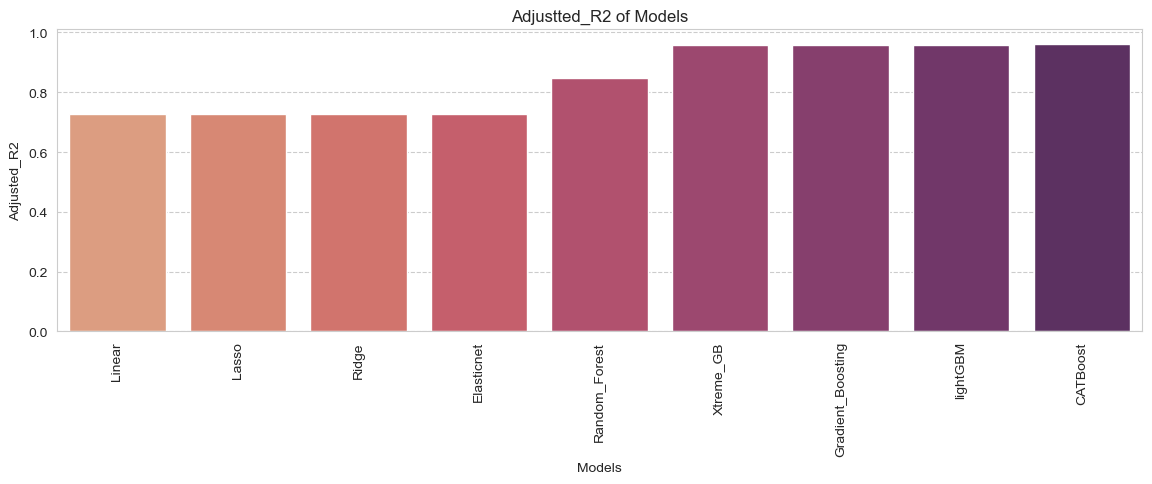

In [121]:
#creating bar plot to visualize the Adjusted R2 of model 

plt.figure(figsize = (14,4), dpi = 100)
sns.barplot(x = 'Models', y = 'Adjusted_R2', data = matrices_df.sort_values('Adjusted_R2'), palette = "flare").set(title = 'Adjustted_R2 of Models')
plt.xticks(rotation = 90)

The Best Model is 'Catboost' (Adj_R2 : 0.961919)

Models 'Random Forest', 'XGBoost', 'lightGBM', 'Gradient Boosting' also<br>
have good performance.

In general, the performance of the model using ensemble techniques<br>
was good.

The worst performance model is LR.

# Conclusion

1. People rent bicycles more on holidays than on working days.<br><br>

2. People rent a lot of bicycles on working days when they commute to work.<br>
&nbsp;They rent bicycles from late morning to afternoon on holidays.<br><br>

3. Both working days and holidays have the lowest rate of bicycle rental<br>
&nbsp;from late evening to dawn.<br><br>

4. Summer and autumn are the seasons when people rent bicycles a lot.<br>
&nbsp;On the contrary, the season when people rent fewer bicycles is spring.<br><br>

5. The clearer the weather, the higher the bicycle rental volumn,<br>
&nbsp;and on days with a lot of snow and rain,<br>
&nbsp;there is almost no bicycle rental volume.<br><br>

6. Bicycle rental is low in temperatures that are too cold or too hot,<br>
&nbsp;but bicycle rental is high in moderate temperatures.<br><br>

7. Overall, the performance of the model using the ensemble technique is good.<br>
&nbsp;Among them, catboost model has the best performance.<br>
&nbsp;Therefore, we recommend using the catboost model<br>
&nbsp;when performing the bike demand prediction work.